# ASEN 6519 Fall 2018 - Midterm Project 
## Extended KF and Ensemble Filters with Lorenz-63

### The Lorenz-63 Model
Low-dimensional model: the state is made of 3 variables $x = (x1, x2, x3)$ and dynamical system evolution is given by the following equations:

$$\frac{\partial x_1}{\partial t} = -Ax_1 + Ax_2$$
$$\frac{\partial x_2}{\partial t} = Bx_1 - x_1x_3 - x_2$$
$$\frac{\partial x_3}{\partial t} = x_1x_2 - Cx_3$$

where $A=10$, $B=28$, and $C=8/3$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dfdt(r, coeffs):
    '''
    Returns dx1/dt, dx2/dt, dx3/dt
    '''
    # Current position
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    
    # Extract coefficients
    A = coeffs[0]
    B = coeffs[1]
    C = coeffs[2]
    
    # Calculate the derivative
    dx1 = -A*x1 + A*x2
    dx2 = B*x1 - x1*x3 - x2
    dx3 = x1*x2 - C*x3
    
    return np.array([dx1, dx2, dx3], float)

### 1. Generate $true$ state and synthetic observations using Lorenz63 setup with the default inputs.

In [3]:
def advance_time(r, coeffs, h):
    '''
    Calculate the state of the system at time t+1 using RK4
    
    Inputs:
        r - the state
        coeffs - the standard Lorenz system coefficients
        h - timstep
    '''
    
    # Calculate Runge-Kutta4 coefficients
    k1 = h*dfdt(r, coeffs)
    k2 = h*dfdt(r+0.5*k1, coeffs)
    k3 = h*dfdt(r+0.5*k2, coeffs)
    k4 = h*dfdt(r+k3, coeffs)
    
    # Update current position
    r += (k1 + 2*k2 + 2*k3 + k4)/6
    
    return r

#### Setup Dynamical Model

In [4]:
## Model setup
N_state = 3 # Number of state variabels
MO = 3      # Number of measurement variables
A_lor = 10  # Default Lorenz system parameters
B_lor = 28
C_lor = 8/3
coeffs = np.array([A_lor, B_lor, C_lor])

# Numerical parameters
t0 = 0          # sec, initial time
tf_assim = 3    # sec, final time
tf_fore = 1     # sec, length of forecast
h_sys = 0.01    # sec, timestep for system dynamics
dyn2meas = 20   # Number of dynamics updates per measurement
h_obs = h_sys * dyn2meas     # sec; an observation is generated every h_obs sec
t_sys = np.arange(t0,tf_assim,h_sys)     # time stamps for system dynamics
t_obs = np.arange(t0,tf_assim,h_obs)     # time stamps for observations
N_sys = len(t_sys)               # Number of system timesteps
N_obs = len(t_obs)               # Number of observations

## Initial conditions
x_true = np.zeros([N_state, N_sys])  # True history of x1 (without any noise)
x_s = np.zeros([N_state, N_sys])     # Noisy history of x1 (with process noise); not used for analysis
y = np.zeros([MO, N_obs])  # Measurements of x1 (with measurement noise)
x1_0 = 1.5
x2_0 = -1.5
x3_0 = 25.5

#### Setup Errors/Covariances/Other Matricies

In [5]:
## Background error variance
var_b = 1   
B_struct = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
B_cov = var_b * B_struct

## Model error covariance (ie: process noise), from Evensen 1997
Q = np.zeros((3,3))
Q[0,0] = 0.1491
Q[0,1] = 0.1505
Q[0,2] = 0.0007
Q[1,0] = 0.1505
Q[1,1] = 0.9048
Q[1,2] = 0.0014
Q[2,0] = 0.0007
Q[2,1] = 0.0014
Q[2,2] = 0.9180
# Qsqrt_cov = np.linalg.cholesky(Q)
L, V = np.linalg.eig(Q)
Qsqrt_cov = V*np.sqrt(L)    # TODO: Why this?

## Misc errors which I do not understand yet but need to run the system
varobs = 3   # Observation error variance
svar = 0.3

## Measurement covariance
sobs = np.sqrt(varobs)
R_struct = np.eye(3)
R = varobs * R_struct
L, V = np.linalg.eig(R)
Msqrt_cov = V*np.sqrt(L)

# ## Generate all the process noise ahead of time
# pnoise_seed = np.random.randn(MO, N_sys)
# pnoise = Qsqrt_cov @ pnoise_seed

H = np.eye(3)

#### Run the System

In [6]:
## Iterate through time and simulate dynamics
r = np.array([[x1_0, x2_0, x3_0]], float).T   # "Current" position

## Set ICs
x_true[:,0] = np.squeeze(r)
x_s[:,0] = np.squeeze(r + svar * np.random.randn(3,1))

for i in range(1,N_sys):
#     # Current time step (i)
#     x_true[:,i] = np.squeeze(r)
    
    # Advance time step (i+1)
    x_true[:,i] = advance_time(x_true[:,i-1], coeffs, h_sys)
    x_s[:,i] = advance_time(x_s[:,i-1], coeffs, h_sys) + \
                np.squeeze(Qsqrt_cov @ np.random.randn(3,1))

#### Generate Measurements

In [7]:
for i in range(N_obs):
    curr_state = x_true[:,i*dyn2meas][:,np.newaxis]
    y[:,i] = np.squeeze(curr_state + Msqrt_cov @ np.random.randn(3,1))

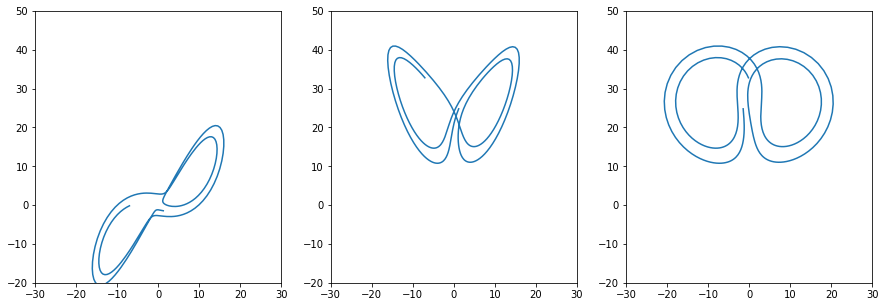

In [8]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1) ; plt.plot(x_true[0,:],x_true[1,:]);plt.ylim(-20,50);plt.xlim(-30,30)
plt.subplot(1,3,2) ; plt.plot(x_true[0,:],x_true[2,:]);plt.ylim(-20,50);plt.xlim(-30,30)
plt.subplot(1,3,3) ; plt.plot(x_true[1,:],x_true[2,:]);plt.ylim(-20,50);plt.xlim(-30,30)
plt.show()

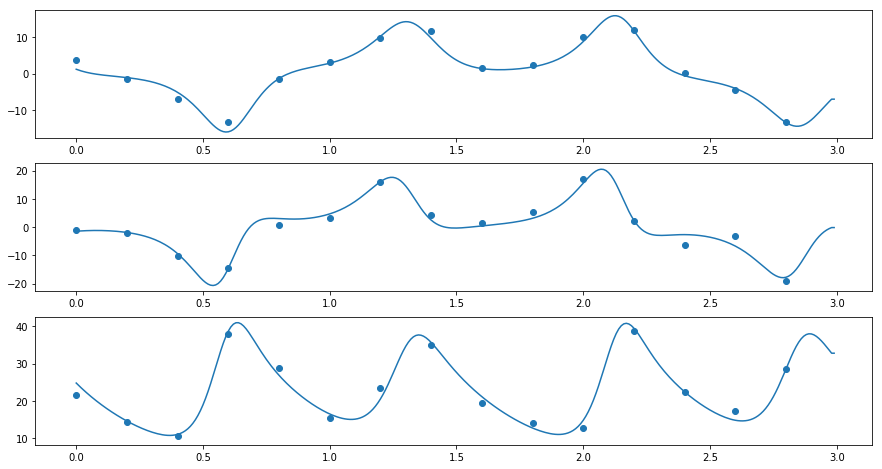

In [9]:
## Plot true state; state evolved with process noise; true state + measurement noise
plt.figure(figsize=[15,8])
plt.subplot(3,1,1) ; plt.plot(t_sys, x_true[0,:]) ; plt.scatter(t_obs, y[0,:])
plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:]) ; plt.scatter(t_obs, y[1,:])
plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:]) ; plt.scatter(t_obs, y[2,:])
plt.show()

### 2. Implement your own EKF to estimate $x_a$. The tangent linear and adjoint codes are provided.
 - Investigate the performance of filter in terms of the bias and mean-square-error of data assimilation analysis. How does the estimate-error computed from xa and the truth value of $x$ compare to the error variance suggested by the posterior covariance?
 - Examine the sensitivity of the filter performance to the errors in the background. (Compare at least 10 cases)
 - Examine the sensitivity of the filter performance to the accuracy and frequency of observations. Is it better to have frequent but inaccurate observations or infrequent but accurate ones? (Compare at least $10\times 10$ cases.)
 
**Extended Kalman Filter Equations**

\begin{equation}
x^f_t = M_{nl, t}(x^a_{t-1})
\end{equation}

\begin{equation}
x^a_t = x^f_t + K_t(y_t - H_{nl, t}(x^f_t)
\end{equation}

\begin{equation}
P^f_t = M_t P^a_{t-1}M^T_t + Q_t
\end{equation}

\begin{equation}
P^a_t = (I = K_t H_t)P^f_t
\end{equation}

Where

\begin{equation}
M_t = \frac{\delta M_{nl, t}}{\delta x} \rvert_{x^a_{t-1}} and H_t = \frac{\delta H_{nl, t}}{\delta x} \rvert_{x^f_{t}}
\end{equation}

In [10]:
def calc_TLM(r, coeffs, h):
    '''
    Calculate the tangent linear model and the adjoint
    '''
    
    ## Unpack inputs
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    A_lor = coeffs[0]
    B_lor = coeffs[1]
    C_lor = coeffs[2]
    
    ## Calculate df1
    drdt = dfdt(r, coeffs)
    dx1 = drdt[0]
    dx2 = drdt[1]
    dx3 = drdt[2]
    
    ## Jacobian at current state, achieved analytically
    GA = np.zeros(3,3)
    GA[0,0] = -dt*A_lor
    GA[1,0] = dt*(B_lor - x3)
    GA[2,0] = dt*x2
    GA[1,0] = dt*A_lor
    GA[1,1] = -dt
    GA[1,2] = dt*x1
    GA[2,0] = 0
    GA[2,1] = -dt*x1
    GA[2,2] = -dt*C_lor
    
    ## Jacobian at future state
    GB = np.zeros(3,3)
    GB[0,0] = -dt*A_lor
    GB[1,0] = dt*(B_lor - (x3+dx3))
    GB[2,0] = dt*(x2+dx2)
    GB[1,0] = dt*A_lor
    GB[1,1] = -dt
    GB[1,2] = dt*(x1+dx1)
    GB[2,0] = 0
    GB[2,1] = -dt*(x1+dx1)
    GB[2,2] = -dt*C_lor
    
    ## TLM
    M = np.eye(3) + 0.5*(GB @ (GA + np.eye(3)) + GA)
    
    return M, M.T

### 3. Implement your own EnKF (with perturb observations) or EnSRF to estimate xa.
 - Initialize the ensemble by introducing small perturbations to the state and integrating the model until its error growth saturates.
 - Compare the performance of the ensemble method to EKF with respect to each sub-question above. Launch ensemble forecasts (instead of deterministic forecasts) at the end of the assimilation period.
 - Evaluate the ensemble by using rank histograms.
 - Examine the impact of increasing or decreasing ensemble size on the filter performance as well as the forecast performance.
 
 **Stochastic EnKF Algorithm** (Katzfuss 2016)
 * Start with an initial ensemble $\hat x_0^{(1)}, ..., \hat x_0^{(N)}$
 * Then at each time $t = 1, 2, ...$, given an ensemble $\hat x_{t-1}^{(1)}, ..., \hat x_{t-1}^{(N)}$ of draws from the filtering (posterior) distribution at time $t-1$ the stochastic EnKF carries out the following two steps for $i = 1, ..., N$.
 * *Forecast* — Draw process noise $w_t^{(i)} \sim N_n(0, Q_t)$ and calculate $\widetilde{x}_t^{(i)} = M_t \hat x_{t-1}^{(i)} + w_t^{(i)}$
 * *Update* — Draw sensor noise $v_t^{(i)} \sim N_{m_t} (0, R_t)$ and calculate $\hat x_t^{(i)} = \widetilde{x}_t^{(i)} + \hat K_t(y_t - \widetilde{y}_t^{(i)} )$
     * where $y_t$ is the actual observation
     * and $\widetilde{y}_t^{(i)} = H_t \widetilde{x}_t^{(i)} - v_t^{(i)}$  is the simulated observation
     * and where $\hat K_t = C_tH_t^T(H_tC_tH_t^T + R_t)^{-1}$
     * and $C_t$ is an estimate of the state forecast covariance matrix $\widetilde{\Sigma}_t$. The simplest example is $C_t = \widetilde{S}_t$, where $\widetilde{S}_t$ is the sample covariance matrix of $\widetilde{x}_t^{(1)}, ..., \widetilde{x}_t^{(N)}$

In [29]:
## Generate initial ensemble
N_ens = 23   # number of ensemble members
xtld_hist = np.zeros((3, N_ens, N_obs))  # History of forecasts (x tilde)
xhat_hist = np.zeros((3, N_ens, N_obs))  # History of updated x's (x hat)
muw = np.zeros(3)   # the mean of process noise
mvw = np.zeros(3)   # the mean of sensor noise
Qh0 = Q               # initlal Q
w0 = np.random.multivariate_normal(muw, Qh0, size=N_ens).T  # Perturbations for the IC
x0_pure = np.array([[x1_0, x2_0, x3_0]]).T   # Unperturbed IC
xh0 = x0_pure + w0 # Initial position of ensemble members
xhat_hist[:,:,0] = xh0

## Move through time
for i in range(1,N_obs):
    ## Forecast
    wt = np.random.multivariate_normal(muw, Q, size=N_ens).T  # Draw process noise
    xtld = advance_time(xhat_hist[:,:,i-1], coeffs, h_obs) + wt
    xtld_hist[:,:,i] = xtld
    
    ## Update
    Ct = np.cov(xtld)    # Calculate sample covariance
    Kt = Ct @ H.T @ np.linalg.inv(H @ Ct @ H + R)  # Calculate Kalman gain
    vt = np.random.multivariate_normal(mvw, R, size=N_ens).T  # Draw measurement noise
    ytld = H@xtld - vt    # Calculate simulated observations
    yact = y[:,i][:,np.newaxis]  # Actual observation
    xhat = xtld + Kt @ (yact - ytld)
    xhat_hist[:,:,i] = xhat

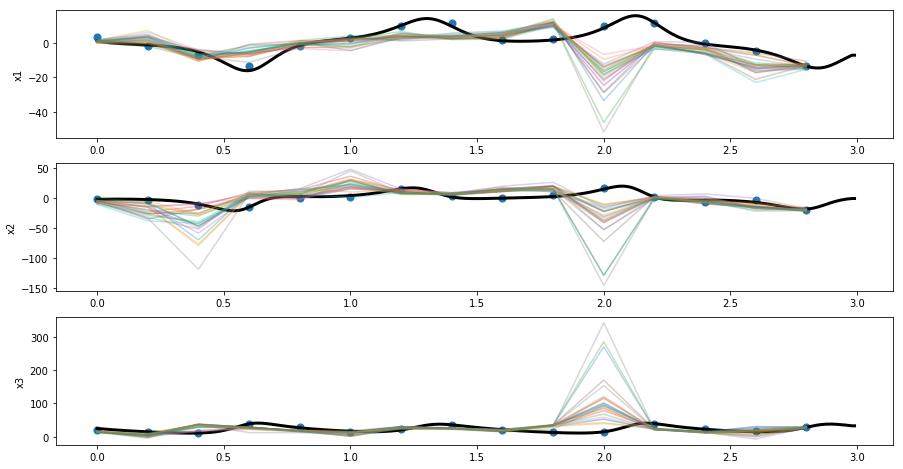

In [49]:
## Plot true state; true state + measurement noise; EnKF update predictions
plt.figure(figsize=[15,8])

## Plot x1
plt.subplot(3,1,1) ; plt.plot(t_sys, x_true[0,:], linewidth=3, color='k') ; plt.scatter(t_obs, y[0,:], s=50)
for i in range(N_ens):
    plt.plot(t_obs, xhat_hist[0,i,:], alpha=0.3)
plt.ylabel('x1')

## Plot x2
plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:], linewidth=3, color='k') ; plt.scatter(t_obs, y[1,:], s=50)
for i in range(N_ens):
    plt.plot(t_obs, xhat_hist[1,i,:], alpha=0.3)
plt.ylabel('x2')

## Plot x3
plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:], linewidth=3, color='k') ; plt.scatter(t_obs, y[2,:], s=50)
for i in range(N_ens):
    plt.plot(t_obs, xhat_hist[2,i,:], alpha=0.3)
plt.ylabel('x3')


# for i in range(N_ens):
#     plt.scatter(t_obs, xh_hist[0,i,:])
# plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:]) ; plt.scatter(t_obs, y[1,:])
# plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:]) ; plt.scatter(t_obs, y[2,:])
plt.show()